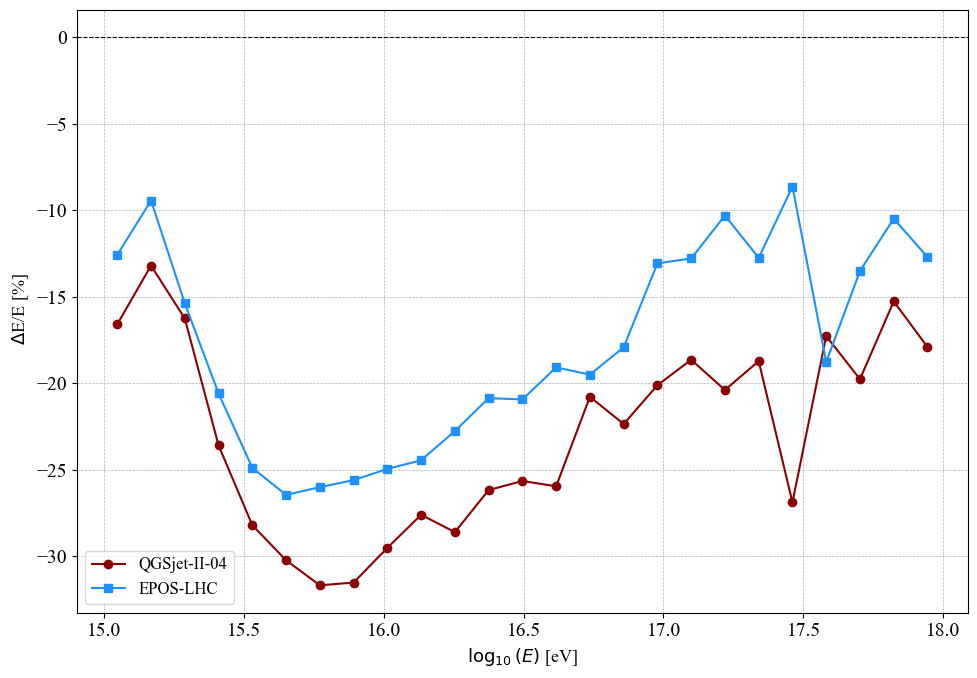

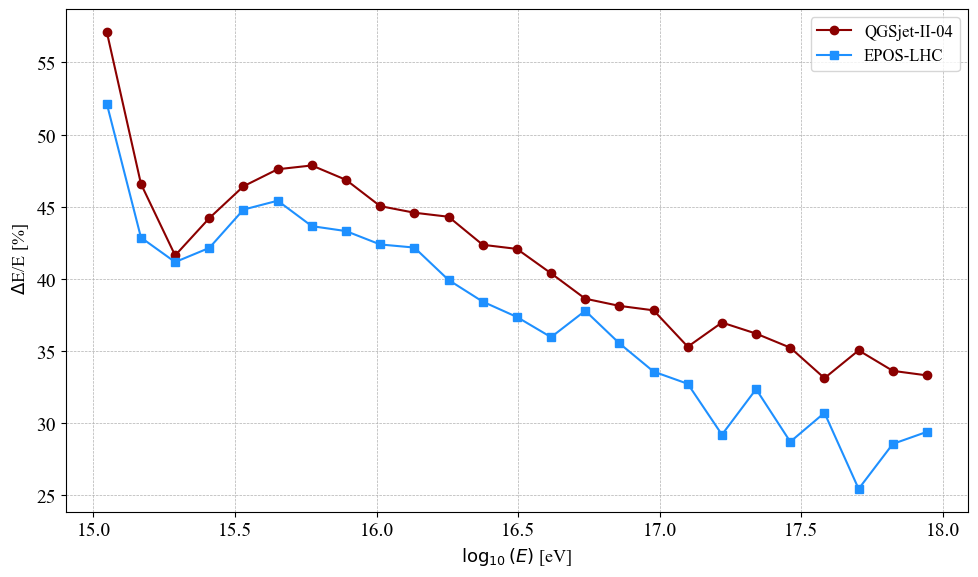

In [23]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- CONFIGURACIÓN ---
files_qgsjet = {
    "Proton": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_pr1.root",
    "Helium": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_he1.root",
    "Carbon": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_co1.root",
    "Silicon": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_si1.root",
    "Iron": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_fe1.root",
    "Gamma": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_gm1.root",
}

files_epos = {
    "Proton": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_pr.root",
    "Helium": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_he.root",
    "Carbon": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_co.root",
    "Silicon": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_si.root",
    "Iron": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_fe.root",
    "Gamma": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_gm.root",
}

# Configuración de bins
n_bins = 50
energy_bins = np.logspace(14.75, 18, n_bins)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

# --- FUNCIONES ---
def load_energy(file_path):
    """Carga energías simuladas y reconstruidas desde un archivo ROOT."""
    with uproot.open(file_path) as file:
        tree_sim = file["trmc;1"]
        energy_sim = 10 ** tree_sim["TrEP"].array(library="np")  # Simulada (log10 a lineal)
        tree_rec = file["comb;1"]
        energy_rec = 10 ** tree_rec["E"].array(library="np")  # Reconstruida (log10 a lineal)
    return energy_sim, energy_rec

# --- GRÁFICO DE BIAS Y RESOLUCIÓN POR LOG10(ET) ---
# Crear un rango de energía log10(ET)
energy_bins = np.logspace(14.5, 18, 30)  # Energías en escala lineal
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2  # Centros de los bins

# Inicializar listas para bias y resolución
bias_qgsjet = []
resolution_qgsjet = []
bias_epos = []
resolution_epos = []

# Calcular bias y resolución por bin de energía
for i in range(len(energy_bins) - 1):
    bin_low, bin_high = energy_bins[i], energy_bins[i + 1]
    
    qgsjet_bias_bin = []
    qgsjet_res_bin = []
    epos_bias_bin = []
    epos_res_bin = []
    
    for primary in files_qgsjet.keys():
        qgsjet_energy_sim, qgsjet_energy_rec = load_energy(files_qgsjet[primary])
        epos_energy_sim, epos_energy_rec = load_energy(files_epos[primary])
        
        # Filtrar datos por bin
        qgsjet_filter = (qgsjet_energy_sim >= bin_low) & (qgsjet_energy_sim < bin_high)
        epos_filter = (epos_energy_sim >= bin_low) & (epos_energy_sim < bin_high)
        
        # Calcular bias y resolución para cada bin
        if np.sum(qgsjet_filter) > 0:
            delta_e_qgsjet = qgsjet_energy_rec[qgsjet_filter] - qgsjet_energy_sim[qgsjet_filter]
            qgsjet_bias_bin.append(100 * np.mean(delta_e_qgsjet / qgsjet_energy_rec[qgsjet_filter]))
            qgsjet_res_bin.append(100 * np.std(delta_e_qgsjet / qgsjet_energy_rec[qgsjet_filter]))
        
        if np.sum(epos_filter) > 0:
            delta_e_epos = epos_energy_rec[epos_filter] - epos_energy_sim[epos_filter]
            epos_bias_bin.append(100 * np.mean(delta_e_epos / epos_energy_rec[epos_filter]))
            epos_res_bin.append(100 * np.std(delta_e_epos / epos_energy_rec[epos_filter]))
    
    # Promediar los valores por bin para ambos modelos
    bias_qgsjet.append(np.mean(qgsjet_bias_bin) if qgsjet_bias_bin else np.nan)
    resolution_qgsjet.append(np.mean(qgsjet_res_bin) if qgsjet_res_bin else np.nan)
    bias_epos.append(np.mean(epos_bias_bin) if epos_bias_bin else np.nan)
    resolution_epos.append(np.mean(epos_res_bin) if epos_res_bin else np.nan)

# Convertir resultados en arrays numpy para facilitar el manejo
bias_qgsjet = np.array(bias_qgsjet)
resolution_qgsjet = np.array(resolution_qgsjet)
bias_epos = np.array(bias_epos)
resolution_epos = np.array(resolution_epos)

# --- GRÁFICO ---
plt.figure(figsize=(10, 7))

# Gráfico de Bias
#plt.subplot(1, 2, 1)
plt.plot(np.log10(bin_centers), bias_qgsjet, label="QGSjet-II-04", color="darkred", marker="o")
plt.plot(np.log10(bin_centers), bias_epos, label="EPOS-LHC", color="dodgerblue", marker="s")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.xlabel(r"$\log_{10}(E)$ [eV]", fontsize=13, fontname='Times New Roman')
plt.ylabel(r" $\Delta$E/E [%]", fontsize=13, fontname='Times New Roman')
plt.legend(fontsize=12)
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.savefig("Bias_Total.pdf", dpi=600)
plt.tight_layout()
plt.show()

# Gráfico de Resolución
#plt.subplot(1, 2, 2)
plt.figure(figsize=(10, 6))
plt.plot(np.log10(bin_centers), resolution_qgsjet, label="QGSjet-II-04", color="darkred", marker="o")
plt.plot(np.log10(bin_centers), resolution_epos, label="EPOS-LHC", color="dodgerblue", marker="s")
plt.xlabel(r"$\log_{10}(E)$ [eV]", fontsize=13, fontname='Times New Roman')
plt.ylabel(r" $\Delta$E/E [%]", fontsize=13, fontname='Times New Roman')
plt.legend(fontsize=12)
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.savefig("Resolucion_Total.pdf", dpi=600)
plt.tight_layout()
plt.show()



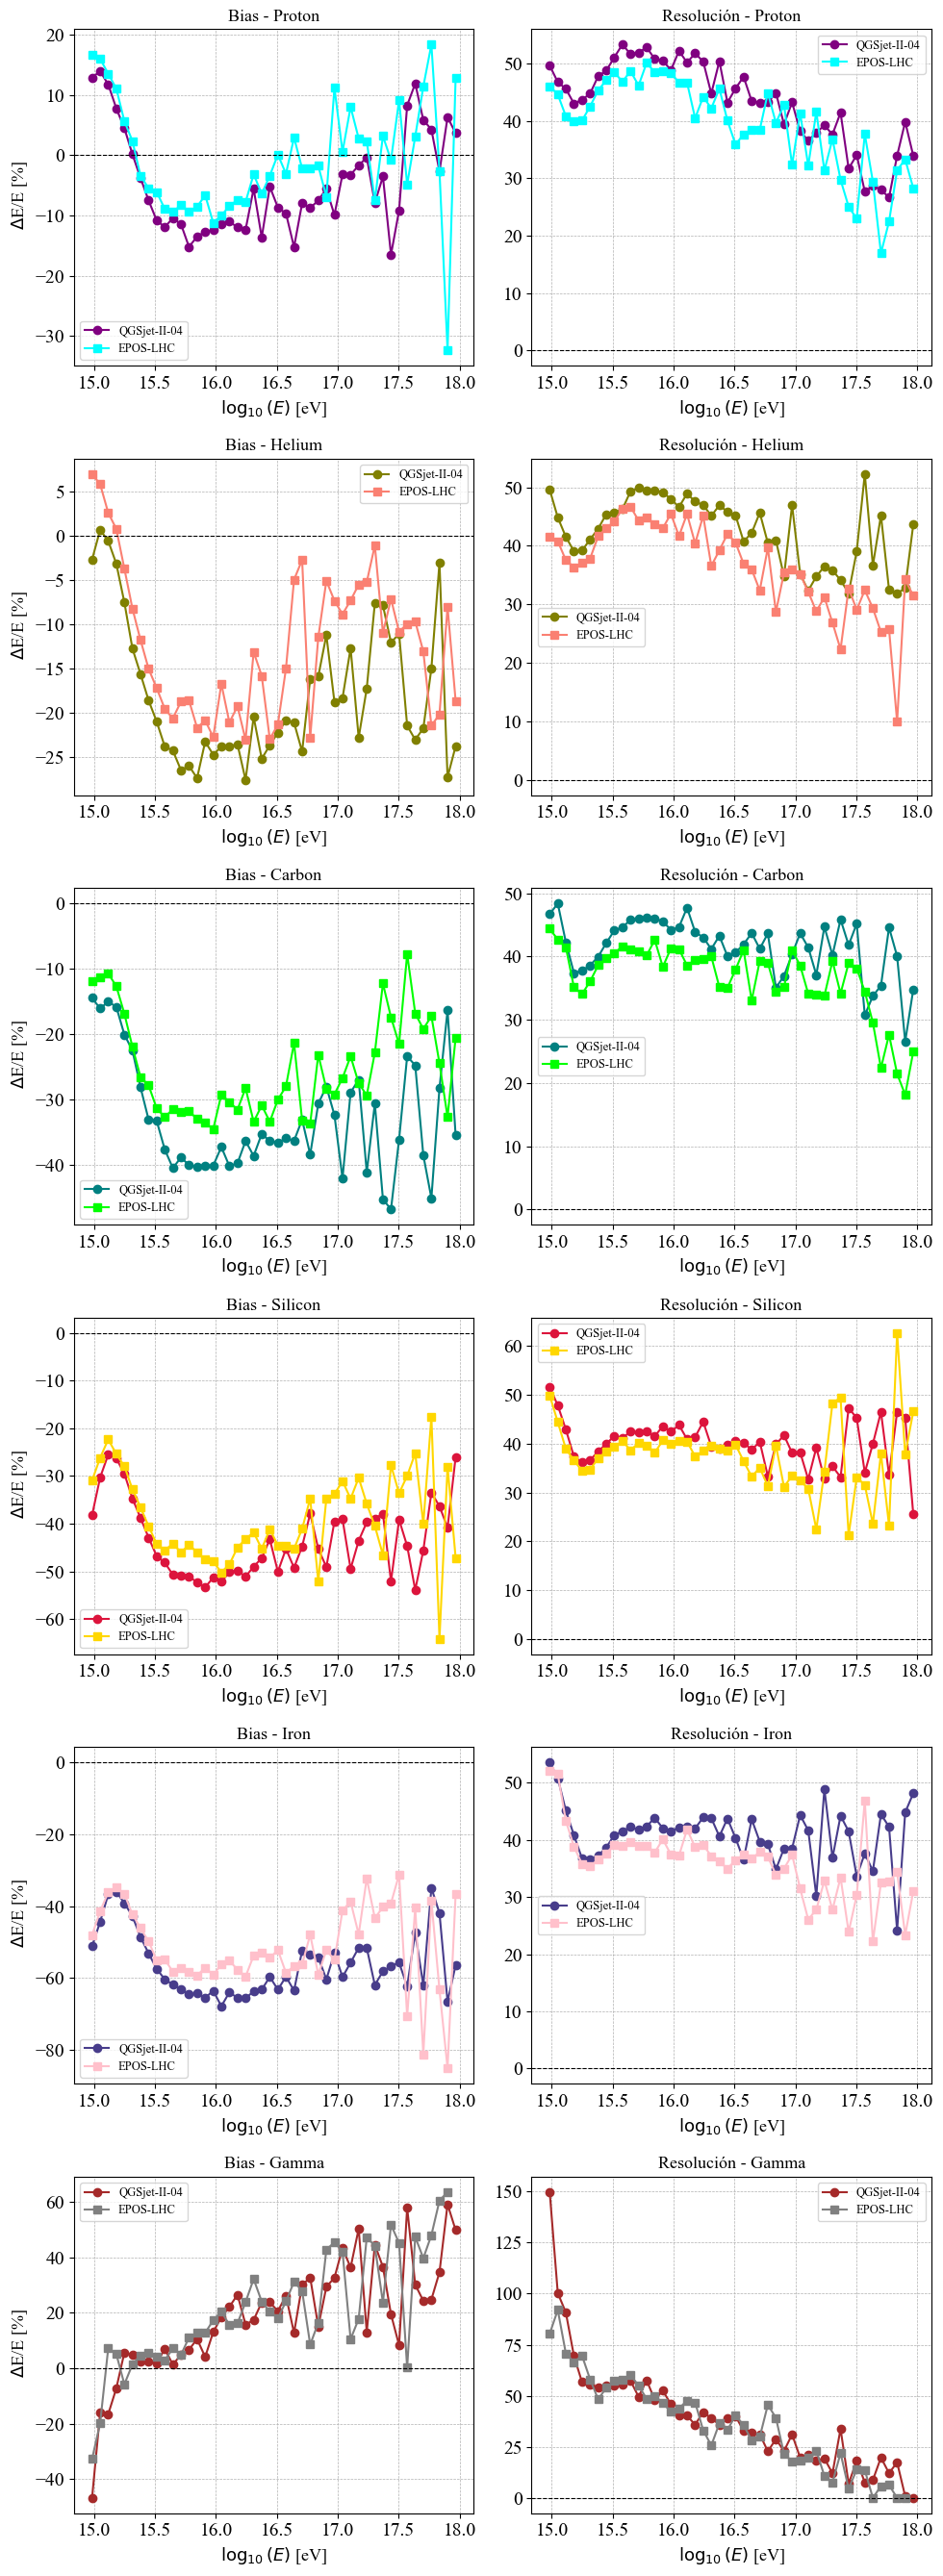

In [21]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- CONFIGURACIÓN ---
files_qgsjet = {
    "Proton": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_pr1.root",
    "Helium": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_he1.root",
    "Carbon": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_co1.root",
    "Silicon": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_si1.root",
    "Iron": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_fe1.root",
    "Gamma": "C:/Users/MSI/extraidos/COMBINED_Sim_qgs-4_gm1.root",
}

files_epos = {
    "Proton": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_pr.root",
    "Helium": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_he.root",
    "Carbon": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_co.root",
    "Silicon": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_si.root",
    "Iron": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_fe.root",
    "Gamma": "C:/Users/MSI/extraidos/COMBINED_Sim_epos-LHC_gm.root",
}

# Configuración de bins
n_bins = 50
energy_bins = np.logspace(14.75, 18, n_bins)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

# --- FUNCIONES ---
def load_energy(file_path):
    """Carga energías simuladas y reconstruidas desde un archivo ROOT."""
    with uproot.open(file_path) as file:
        tree_sim = file["trmc;1"]
        energy_sim = 10** tree_sim["TrEP"].array(library="np")  # Simulada (log10 a lineal)
        tree_rec = file["comb;1"]
        energy_rec = 10** tree_rec["E"].array(library="np")  # Reconstruida (log10 a lineal)
    return energy_sim, energy_rec

# --- CÁLCULO DE BIAS Y RESOLUCIÓN POR PRIMARIO ---
plt.figure(figsize=(10, 27))
colors_bias = ["purple", "olive", "teal", "crimson", "darkslateblue", "brown"]
colors_res = ["cyan", "salmon", "lime", "gold", "pink", "gray"]

for i, primary in enumerate(files_qgsjet.keys()):
    bias_qgsjet = []
    resolution_qgsjet = []
    bias_epos = []
    resolution_epos = []

    for j in range(len(energy_bins) - 1):
        bin_low, bin_high = energy_bins[j], energy_bins[j + 1]

        # Cargar energías simuladas y reconstruidas
        qgsjet_energy_sim, qgsjet_energy_rec = load_energy(files_qgsjet[primary])
        epos_energy_sim, epos_energy_rec = load_energy(files_epos[primary])

        # Filtrar datos dentro del bin
        qgsjet_filter = (qgsjet_energy_sim >= bin_low) & (qgsjet_energy_sim < bin_high)
        epos_filter = (epos_energy_sim >= bin_low) & (epos_energy_sim < bin_high)

        # Calcular bias y resolución
        if np.sum(qgsjet_filter) > 0:
            delta_e_qgsjet = qgsjet_energy_rec[qgsjet_filter] - qgsjet_energy_sim[qgsjet_filter]
            bias_qgsjet.append(100* np.mean(delta_e_qgsjet / qgsjet_energy_rec[qgsjet_filter]))
            resolution_qgsjet.append(100* np.std(delta_e_qgsjet / qgsjet_energy_rec[qgsjet_filter]))
        else:
            bias_qgsjet.append(np.nan)
            resolution_qgsjet.append(np.nan)

        if np.sum(epos_filter) > 0:
            delta_e_epos = epos_energy_rec[epos_filter] - epos_energy_sim[epos_filter]
            bias_epos.append(100* np.mean(delta_e_epos / epos_energy_rec[epos_filter]))
            resolution_epos.append(100 *np.std(delta_e_epos / epos_energy_rec[epos_filter]))
        else:
            bias_epos.append(np.nan)
            resolution_epos.append(np.nan)

    # Graficar Bias
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(np.log10(bin_centers), bias_qgsjet, label="QGSjet-II-04", color=colors_bias[i], marker="o")
    plt.plot(np.log10(bin_centers), bias_epos, label="EPOS-LHC", color=colors_res[i], marker="s")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.xlabel(r"$\log_{10}(E)$ [eV]", fontsize=13, fontname='Times New Roman')
    plt.ylabel(r" $\Delta$E/E [%]", fontsize=13, fontname='Times New Roman')
    plt.title(f"Bias - {primary}", fontsize=13, fontname='Times New Roman')
    plt.legend(fontsize=9)
    plt.grid(which="both", linestyle="--", linewidth=0.5)

    # Graficar Resolución
    plt.subplot(6, 2, 2 * i + 2)
    plt.plot(np.log10(bin_centers), resolution_qgsjet, label="QGSjet-II-04", color=colors_bias[i], marker="o")
    plt.plot(np.log10(bin_centers), resolution_epos, label="EPOS-LHC", color=colors_res[i], marker="s")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.xlabel(r"$\log_{10}(E)$ [eV]", fontsize=13, fontname='Times New Roman')
    #plt.ylabel(r" $\Delta$E/E %", fontsize=13, fontname='Times New Roman')
    plt.title(f"Resolución - {primary}", fontsize=13, fontname='Times New Roman')
    plt.legend(fontsize=9)
    plt.grid(which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig("Bias_Resolucion_Por_Primario.pdf", dpi=600)
plt.show()



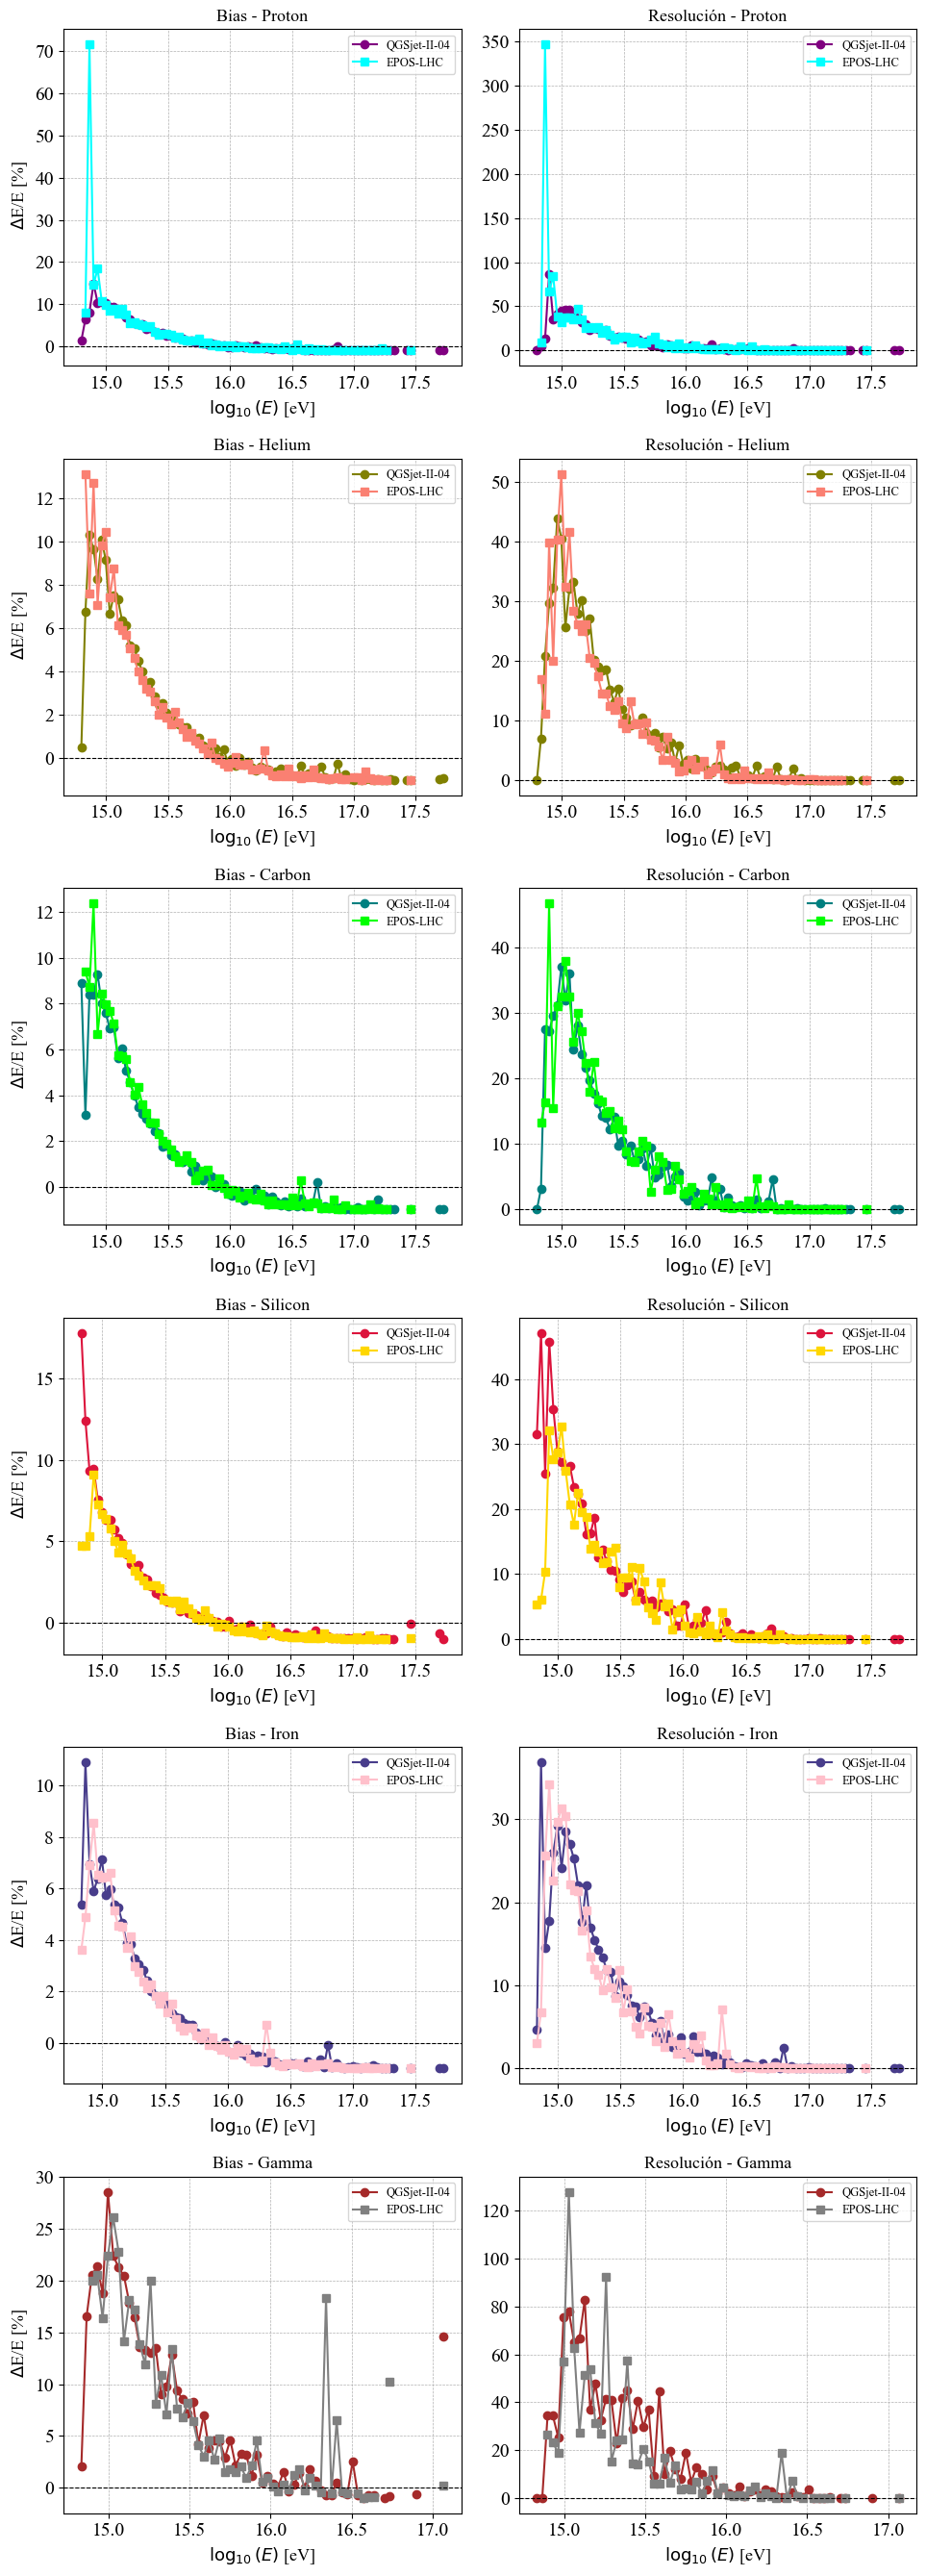

In [38]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- CONFIGURACIÓN ---
BASE_PATH = "C:/Users/MSI/extraidos/"
REAL_FILE = f"{BASE_PATH}events.root"

files_qgsjet = {
    "Proton": f"{BASE_PATH}COMBINED_Sim_qgs-4_pr1.root",
    "Helium": f"{BASE_PATH}COMBINED_Sim_qgs-4_he1.root",
    "Carbon": f"{BASE_PATH}COMBINED_Sim_qgs-4_co1.root",
    "Silicon": f"{BASE_PATH}COMBINED_Sim_qgs-4_si1.root",
    "Iron": f"{BASE_PATH}COMBINED_Sim_qgs-4_fe1.root",
    "Gamma": f"{BASE_PATH}COMBINED_Sim_qgs-4_gm1.root",
}

files_epos = {
    "Proton": f"{BASE_PATH}COMBINED_Sim_epos-LHC_pr.root",
    "Helium": f"{BASE_PATH}COMBINED_Sim_epos-LHC_he.root",
    "Carbon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_co.root",
    "Silicon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_si.root",
    "Iron": f"{BASE_PATH}COMBINED_Sim_epos-LHC_fe.root",
    "Gamma": f"{BASE_PATH}COMBINED_Sim_epos-LHC_gm.root",
}

# Configuración de bins
n_bins = 100
energy_bins = np.logspace(14.75, 18, n_bins)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

# --- FUNCIONES ---
def load_energy(file_path):
    """Carga energías reconstruidas desde ROOT."""
    with uproot.open(file_path) as file:
        tree_rec = file["comb;1"]
        energy_rec = 10 ** tree_rec["E"].array(library="np")  # Reconstruida (log10 a lineal)
    return energy_rec

# Cargar la energía verdadera del archivo de eventos reales
def load_true_energy():
    """Carga la energía verdadera desde el archivo events.root."""
    with uproot.open(REAL_FILE) as file:
        tree_true = file["combined"]
        energy_true = 10 ** tree_true["E"].array(library="np")  # Energía verdadera
    return energy_true

energy_true = load_true_energy()

# Asegurar que todas las listas tengan la misma longitud
def match_events(energy_rec, energy_true):
    min_len = min(len(energy_rec), len(energy_true))
    return energy_rec[:min_len], energy_true[:min_len]

# --- CÁLCULO DE BIAS Y RESOLUCIÓN POR PRIMARIO ---
plt.figure(figsize=(10, 27))
colors_bias = ["purple", "olive", "teal", "crimson", "darkslateblue", "brown"]
colors_res = ["cyan", "salmon", "lime", "gold", "pink", "gray"]

for i, primary in enumerate(files_qgsjet.keys()):
    bias_qgsjet = []
    resolution_qgsjet = []
    bias_epos = []
    resolution_epos = []

    for j in range(len(energy_bins) - 1):
        bin_low, bin_high = energy_bins[j], energy_bins[j + 1]

        qgsjet_energy_rec = load_energy(files_qgsjet[primary])
        epos_energy_rec = load_energy(files_epos[primary])

        qgsjet_energy_rec, matched_true_qgsjet = match_events(qgsjet_energy_rec, energy_true)
        epos_energy_rec, matched_true_epos = match_events(epos_energy_rec, energy_true)

        qgsjet_filter = (matched_true_qgsjet >= bin_low) & (matched_true_qgsjet < bin_high)
        epos_filter = (matched_true_epos >= bin_low) & (matched_true_epos < bin_high)

        if np.sum(qgsjet_filter) > 0:
            delta_e_qgsjet = matched_true_qgsjet[qgsjet_filter]- qgsjet_energy_rec[qgsjet_filter]
            bias_qgsjet.append(np.mean((qgsjet_energy_rec[qgsjet_filter]- matched_true_qgsjet[qgsjet_filter])/ matched_true_qgsjet[qgsjet_filter]))
            resolution_qgsjet.append(np.std(delta_e_qgsjet / matched_true_qgsjet[qgsjet_filter]))
        else:
            bias_qgsjet.append(np.nan)
            resolution_qgsjet.append(np.nan)

        if np.sum(epos_filter) > 0:
            delta_e_epos = matched_true_epos[epos_filter] - epos_energy_rec[epos_filter]
            bias_epos.append(np.mean((epos_energy_rec[epos_filter] - matched_true_epos[epos_filter]) / matched_true_epos[epos_filter]))
            resolution_epos.append(np.std(delta_e_epos / matched_true_epos[epos_filter]))
        else:
            bias_epos.append(np.nan)
            resolution_epos.append(np.nan)

    # Graficar Bias
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(np.log10(bin_centers), bias_qgsjet, label="QGSjet-II-04", color=colors_bias[i], marker="o")
    plt.plot(np.log10(bin_centers), bias_epos, label="EPOS-LHC", color=colors_res[i], marker="s")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.xlabel(r"$\log_{10}(E)$ [eV]", fontsize=13, fontname='Times New Roman')
    plt.ylabel(r" $\Delta$E/E [%]", fontsize=13, fontname='Times New Roman')
    plt.title(f"Bias - {primary}", fontsize=13, fontname='Times New Roman')
    plt.legend(fontsize=9)
    plt.grid(which="both", linestyle="--", linewidth=0.5)

    # Graficar Resolución
    plt.subplot(6, 2, 2 * i + 2)
    plt.plot(np.log10(bin_centers), resolution_qgsjet, label="QGSjet-II-04", color=colors_bias[i], marker="o")
    plt.plot(np.log10(bin_centers), resolution_epos, label="EPOS-LHC", color=colors_res[i], marker="s")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.xlabel(r"$\log_{10}(E)$ [eV]", fontsize=13, fontname='Times New Roman')
    plt.title(f"Resolución - {primary}", fontsize=13, fontname='Times New Roman')
    plt.legend(fontsize=9)
    plt.grid(which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig("Bias_Resolucion_Por_Primario.pdf", dpi=600)
plt.show()

        # Cálculo del Bias (%)
        bias = np.mean((energy_sim - energy_rec) / energy_rec) * 100

        # Cálculo de la Resolución (%)
        resolution = (np.std(energy_rec))/np.mean(energy_))

        return bias, resolution

# --- Cálculo e Impresión de Resultados ---
print("\n--- Bias y Resolución de Energía por Primario y Modelo ---")
print("{:<12} {:<12} {:<15} {:<15}".format("Modelo", "Primario", "Bias (%)", "Resolución (%)"))
print("-" * 60)

for model, primaries in MODELS.items():
    for primary, file_path in primaries.items():
        bias, resolution = calculate_bias_resolution(file_path)
        if bias is not None and resolution is not None:
            print("{:<12} {:<12} {:<15.2f} {:<15.2f}".format(model, primary, bias, resolution))
        else:
            print("{:<12} {:<12} {:<15} {:<15}".format(model, primary, "N/A", "N/A"))


In [40]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- CONFIGURACIÓN ---
BASE_PATH = "C:/Users/MSI/extraidos/"
REAL_FILE = f"{BASE_PATH}events.root"

files_qgsjet = {
    "Proton": f"{BASE_PATH}COMBINED_Sim_qgs-4_pr1.root",
    "Helium": f"{BASE_PATH}COMBINED_Sim_qgs-4_he1.root",
    "Carbon": f"{BASE_PATH}COMBINED_Sim_qgs-4_co1.root",
    "Silicon": f"{BASE_PATH}COMBINED_Sim_qgs-4_si1.root",
    "Iron": f"{BASE_PATH}COMBINED_Sim_qgs-4_fe1.root",
    "Gamma": f"{BASE_PATH}COMBINED_Sim_qgs-4_gm1.root",
}

files_epos = {
    "Proton": f"{BASE_PATH}COMBINED_Sim_epos-LHC_pr.root",
    "Helium": f"{BASE_PATH}COMBINED_Sim_epos-LHC_he.root",
    "Carbon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_co.root",
    "Silicon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_si.root",
    "Iron": f"{BASE_PATH}COMBINED_Sim_epos-LHC_fe.root",
    "Gamma": f"{BASE_PATH}COMBINED_Sim_epos-LHC_gm.root",
}

# --- FUNCIONES ---
def load_energy(file_path):
    """Carga energías reconstruidas desde ROOT."""
    with uproot.open(file_path) as file:
        tree_rec = file["comb;1"]
        energy_rec = 10 ** tree_rec["E"].array(library="np")  # Energía reconstruida
    return energy_rec

def load_true_energy():
    """Carga la energía verdadera desde el archivo events.root."""
    with uproot.open(REAL_FILE) as file:
        tree_true = file["combined"]
        energy_true = 10 ** tree_true["E"].array(library="np")  # Energía verdadera
    return energy_true

def match_events(energy_rec, energy_true):
    min_len = min(len(energy_rec), len(energy_true))
    return energy_rec[:min_len], energy_true[:min_len]

# --- CÁLCULO DE BIAS Y RESOLUCIÓN ---
energy_true = load_true_energy()
results = []

for primary in files_qgsjet.keys():
    # Cargar datos para QGSjet
    qgsjet_energy_rec = load_energy(files_qgsjet[primary])
    qgsjet_energy_rec, qgsjet_true = match_events(qgsjet_energy_rec, energy_true)
    
    # Calcular métricas para QGSjet
    delta_qgsjet = (qgsjet_energy_rec - qgsjet_true) / qgsjet_true
    bias_qgsjet = np.nanmean(delta_qgsjet) # Bias en %
    resolution_qgsjet = np.nanstd(delta_qgsjet) # Resolución en %
    
    # Cargar datos para EPOS
    epos_energy_rec = load_energy(files_epos[primary])
    epos_energy_rec, epos_true = match_events(epos_energy_rec, energy_true)
    
    # Calcular métricas para EPOS
    delta_epos = (epos_energy_rec - epos_true) / epos_true
    bias_epos = np.nanmean(delta_epos) 
    resolution_epos = np.nanstd(delta_epos)
    
    results.append(("QGSjet-II-04", primary, bias_qgsjet, resolution_qgsjet))
    results.append(("EPOS-LHC", primary, bias_epos, resolution_epos))

# --- IMPRIMIR TABLA ---
print("\n--- Resultados de Bias y Resolución ---")
print("{:<15} {:<10} {:<15} {:<15}".format("Modelo", "Primario", "Bias (%)", "Resolución (%)"))
print("-" * 55)
for entry in results:
    modelo, primario, bias, resol = entry
    print("{:<15} {:<10} {:<15.2f} {:<15.2f}".format(modelo, primario, bias, resol))

# --- GUARDAR EN ARCHIVO ROOT (OPCIONAL) ---
# with uproot.recreate("resultados_bias_resolucion.root") as f:
#     f["tabla"] = {
#         "Modelo": [entry[0] for entry in results],
#         "Primario": [entry[1] for entry in results],
#         "Bias": [entry[2] for entry in results],
#         "Resolucion": [entry[3] for entry in results]
#     }


--- Resultados de Bias y Resolución ---
Modelo          Primario   Bias (%)        Resolución (%) 
-------------------------------------------------------
QGSjet-II-04    Proton     4.90            27.22          
EPOS-LHC        Proton     5.00            28.07          
QGSjet-II-04    Helium     4.11            22.29          
EPOS-LHC        Helium     3.95            22.20          
QGSjet-II-04    Carbon     3.47            19.90          
EPOS-LHC        Carbon     3.67            20.79          
QGSjet-II-04    Silicon    3.23            18.02          
EPOS-LHC        Silicon    3.11            17.21          
QGSjet-II-04    Iron       3.07            17.80          
EPOS-LHC        Iron       3.01            16.92          
QGSjet-II-04    Gamma      12.30           46.21          
EPOS-LHC        Gamma      11.76           46.89          


In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
BASE_PATH = "C:/Users/MSI/extraidos/"
REAL_FILE = f"{BASE_PATH}events.root"

files_qgsjet = {
    "Proton": f"{BASE_PATH}COMBINED_Sim_qgs-4_pr1.root",
    "Helium": f"{BASE_PATH}COMBINED_Sim_qgs-4_he1.root",
    "Carbon": f"{BASE_PATH}COMBINED_Sim_qgs-4_co1.root",
    "Silicon": f"{BASE_PATH}COMBINED_Sim_qgs-4_si1.root",
    "Iron": f"{BASE_PATH}COMBINED_Sim_qgs-4_fe1.root",
    "Gamma": f"{BASE_PATH}COMBINED_Sim_qgs-4_gm1.root",
}

files_epos = {
    "Proton": f"{BASE_PATH}COMBINED_Sim_epos-LHC_pr.root",
    "Helium": f"{BASE_PATH}COMBINED_Sim_epos-LHC_he.root",
    "Carbon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_co.root",
    "Silicon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_si.root",
    "Iron": f"{BASE_PATH}COMBINED_Sim_epos-LHC_fe.root",
    "Gamma": f"{BASE_PATH}COMBINED_Sim_epos-LHC_gm.root",
}

# Configuración de bins
n_bins = 100
energy_bins = np.logspace(14.95, 18, n_bins)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])
log_bin_centers = np.log10(bin_centers)

# --- FUNCIONES ---
def load_energy(file_path):
    with uproot.open(file_path) as file:
        return 10**file["comb;1"]["E"].array(library="np")

def load_true_energy():
    with uproot.open(REAL_FILE) as file:
        return 10**file["combined"]["E"].array(library="np")

def match_events(rec, true):
    min_len = min(len(rec), len(true))
    return rec[:min_len], true[:min_len]

# --- CÁLCULO Y GRÁFICOS ---
energy_true = load_true_energy()
all_res = {"QGSjet": {}, "EPOS": {}}

# Gráficos individuales por primario
for primary in files_qgsjet.keys():
    # Cargar datos
    qgs_rec, qgs_true = match_events(load_energy(files_qgsjet[primary]), energy_true)
    epos_rec, epos_true = match_events(load_energy(files_epos[primary]), energy_true)
    
    # Inicializar almacenamiento
    bias_qgs, res_qgs = [], []
    bias_epos, res_epos = [], []

    # Calcular por bin
    for j in range(len(energy_bins)-1):
        mask_qgs = (qgs_true >= energy_bins[j]) & (qgs_true < energy_bins[j+1])
        mask_epos = (epos_true >= energy_bins[j]) & (epos_true < energy_bins[j+1])
        
        # QGSjet
        if np.sum(mask_qgs) > 10:  # Mínimo estadístico
            delta = (qgs_rec[mask_qgs] - qgs_true[mask_qgs])/qgs_true[mask_qgs]
            bias_qgs.append(np.mean(delta))
            res_qgs.append(np.std(delta))
        else:
            bias_qgs.append(np.nan)
            res_qgs.append(np.nan)
            
        # EPOS
        if np.sum(mask_epos) > 10:
            delta = (epos_rec[mask_epos] - epos_true[mask_epos])/epos_true[mask_epos]
            bias_epos.append(np.mean(delta))
            res_epos.append(np.std(delta))
        else:
            bias_epos.append(np.nan)
            res_epos.append(np.nan)
    
    # Almacenar para gráficos combinados
    all_res["QGSjet"][primary] = res_qgs
    all_res["EPOS"][primary] = res_epos

    # Gráfico individual del primario
    plt.figure(figsize=(12, 5))
    
    # Subplot Bias
    plt.subplot(1, 2, 1)
    plt.plot(log_bin_centers, bias_qgs, 'o-', color="darkred", label='QGSjet-II-04')
    plt.plot(log_bin_centers, bias_epos, 's--', color="dodgerblue", label='EPOS-LHC')
    plt.axhline(0, color='gray', ls='--', lw=1)
    plt.xlabel(r'$\log_{10}(E_{\text{true}})$ [eV]', fontsize=12)
    plt.ylabel('Bias (%)', fontsize=12)
    plt.title(f'Bias - {primary}', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Subplot Resolución
    plt.subplot(1, 2, 2)
    plt.plot(log_bin_centers, res_qgs, 'o-', color="darkred", label='QGSjet-II-04')
    plt.plot(log_bin_centers, res_epos, 's--', color="dodgerblue", label='EPOS-LHC')
    plt.xlabel(r'$\log_{10}(E_{\text{true}})$ [eV]', fontsize=12)
    plt.ylabel('Resolución (%)', fontsize=12)
    plt.title(f'Resolución - {primary}', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'Bias_Res_{primary}.pdf', dpi=600)
    plt.close()

# Gráficos combinados de resolución
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors
for i, (primary, res) in enumerate(all_res["QGSjet"].items()):
    plt.plot(log_bin_centers, res, color=colors[i], marker='o', linestyle='-', label=primary)
plt.xlabel(r'$\log_{10}(E_{\text{true}})$ [eV]', fontsize=12)
plt.ylabel('Resolución (%)', fontsize=12)
plt.title('Resolución Energética - QGSjet-II-04', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('Resolucion_QGSjet_All.pdf', dpi=600)
plt.close()

plt.figure(figsize=(10, 6))
for i, (primary, res) in enumerate(all_res["EPOS"].items()):
    plt.plot(log_bin_centers, res, color=colors[i], marker='s', linestyle='--', label=primary)
plt.xlabel(r'$\log_{10}(E_{\text{true}})$ [eV]', fontsize=12)
plt.ylabel('Resolución (%)', fontsize=12)
plt.title('Resolución Energética - EPOS-LHC', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('Resolucion_EPOS_All.pdf', dpi=600)
plt.close()